# **Importing Modules and Dependencies**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import os

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# **Data**

In [ ]:
root='drive/MyDrive/NAAMII_research_assistant/data'
train_data = datasets.ImageFolder(root=f'{root}/train',
                                  transform=transforms.ToTensor()) #0-255 to 0-1

In [ ]:
test_data = datasets.ImageFolder(root=f'{root}/test',
                                  transform=transforms.ToTensor()) #0-255 to 0-1

In [ ]:
#show img and label
count=0
for img, label in train_data:
  count=count+1
  print(f'{img}   /   {label}')
  if count>3:
    break

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])   /   0
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 

In [ ]:
root_path='drive/MyDrive/NAAMII_research_assistant/data'

print('train')
for folder in train_data.classes:
  print(f'{folder} - {len(os.listdir(os.path.join(f"{root_path}/train",folder)))}')
print('\n')

print('test')
for folder in test_data.classes:
  print(f'{folder} - {len(os.listdir(os.path.join(f"{root_path}/test",folder)))}')
print('\n')

train
Parasitized - 11023
Uninfected - 10975


test
Parasitized - 2756
Uninfected - 2756




In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

train_transformer = transforms.Compose([
    transforms.Resize([pretrained_size,pretrained_size]),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=pretrained_means,
                         std=pretrained_stds)
])

test_transformer = transforms.Compose([
    transforms.Resize([pretrained_size,pretrained_size]),
    transforms.ToTensor(),
    transforms.Normalize(mean=pretrained_means,
                         std=pretrained_stds)
])

In [ ]:
train_data=datasets.ImageFolder(root=f'{root}/train',
                                  transform=train_transformer)

test_data = datasets.ImageFolder(root=f'{root}/test',
                                  transform=test_transformer)

In [ ]:
print(len(train_data))
print(len(test_data))

21998
5512


In [ ]:
train_loader=data.DataLoader(train_data,
                             batch_size=32,
                             shuffle=True)

test_loader=data.DataLoader(test_data,
                             batch_size=16,
                             shuffle=True)

In [ ]:
print(len(train_loader))
print(len(test_loader))

688
345


In [ ]:
classes=train_data.classes
print(classes)
num_classes=len(classes)
print(num_classes)

['Parasitized', 'Uninfected']
2


# **Model**

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [ ]:
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
                'M', 512, 512, 512, 'M']

In [ ]:
def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [ ]:
vgg16_layers = get_vgg_layers(vgg16_config, batch_norm=True)

In [ ]:
print(vgg16_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [ ]:
OUTPUT_DIM = 2

model = VGG(vgg16_layers, OUTPUT_DIM)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# **Pretrained model VGG16**

In [ ]:
pretrained_model = models.vgg16_bn(pretrained=True)

In [ ]:
# pretrained_model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

In [ ]:
print(pretrained_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
pretrained_model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
OUTPUT_DIM=2

IN_FEATURES = pretrained_model.classifier[-1].in_features

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

In [ ]:
pretrained_model.classifier[-1] = final_fc

In [ ]:
print(pretrained_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


In [ ]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 134,277,186 trainable parameters


In [ ]:
# #optimizer and loss function
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
LR = 5e-4

params = [
          {'params': model.features.parameters(), 'lr': LR / 10},
          {'params': model.classifier.parameters()}
         ]

optimizer = optim.Adam(params, lr=LR)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
from tqdm import tqdm


def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
num_epochs=5
save_model_path=os.path.join('/content/drive/MyDrive/NAAMII_research_assistant/models/model_vgg16.pt')

best_valid_loss = float('inf')

total_train_loss=[]
total_val_loss=[]

total_train_accuracy=[]
total_val_accuracy=[]

for epoch in trange(num_epochs,desc='Epochs'):
    
    start_time=time.monotonic()

    train_loss,train_accuracy=train(model,train_loader, optimizer,criterion,device)
    total_train_loss.append(train_loss)
    total_train_accuracy.append(train_accuracy)
    
    evaluate_loss,val_accuracy=evaluate(model,test_loader,criterion,device)
    total_val_loss.append(evaluate_loss)
    total_val_accuracy.append(val_accuracy)

    if evaluate_loss<best_valid_loss:
        best_valid_loss=evaluate_loss
        torch.save(model.state_dict(),save_model_path)

    end_time=time.monotonic()

    epoch_mins,epoch_sec=epoch_time(start_time,end_time)

    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_sec}s')
    print(f'\tTrain Loss: {train_loss}   |    Train accuracy: {train_accuracy}')
    print(f'\t Val. Loss: {evaluate_loss}   |   Val. accuacy: {val_accuracy}')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]


Training: 100%|██████████| 688/688 [1:24:10<00:00,  6.33s/it]
                                                             
Evaluating: 100%|██████████| 345/345 [20:04<00:00,  2.98s/it]
                                                             

Epoch: 01 | Time: 104m 17s
	Train Loss: 0.1451711464533853   |    Train accuracy: 0.9542021387538244
	 Val. Loss: 0.18528022810941616   |   Val. accuacy: 0.9536231884057971



Training: 100%|██████████| 688/688 [07:50<00:00,  1.74it/s]
                                                           
Evaluating: 100%|█████████▉| 344/345 [00:53<00:00,  6.61it/s]
                                                             

Epoch: 02 | Time: 8m 46s
	Train Loss: 0.10069158370462775   |    Train accuracy: 0.9682957848837209
	 Val. Loss: 0.15692600227480727   |   Val. accuacy: 0.9538043478260869



Training: 100%|██████████| 688/688 [07:49<00:00,  1.72it/s]
                                                           
Evaluating: 100%|█████████▉| 344/345 [00:53<00:00,  6.57it/s]
                                                             

Epoch: 03 | Time: 8m 45s
	Train Loss: 0.09110960022760907   |    Train accuracy: 0.9705214389534884
	 Val. Loss: 0.1373456732572421   |   Val. accuacy: 0.9527173913043478



Training: 100%|██████████| 688/688 [07:49<00:00,  1.73it/s]
                                                           
Evaluating: 100%|█████████▉| 344/345 [00:53<00:00,  6.38it/s]
                                                             

Epoch: 04 | Time: 8m 43s
	Train Loss: 0.07773721702501779   |    Train accuracy: 0.9747002180232558
	 Val. Loss: 0.13964208153690602   |   Val. accuacy: 0.9559782608695652



Training: 100%|██████████| 688/688 [07:49<00:00,  1.70it/s]
                                                           
Evaluating: 100%|█████████▉| 344/345 [00:54<00:00,  6.16it/s]
                                                             

Epoch: 05 | Time: 8m 43s
	Train Loss: 0.07529099221168042   |    Train accuracy: 0.9767441860465116
	 Val. Loss: 0.13842717731182558   |   Val. accuacy: 0.9556159420289855


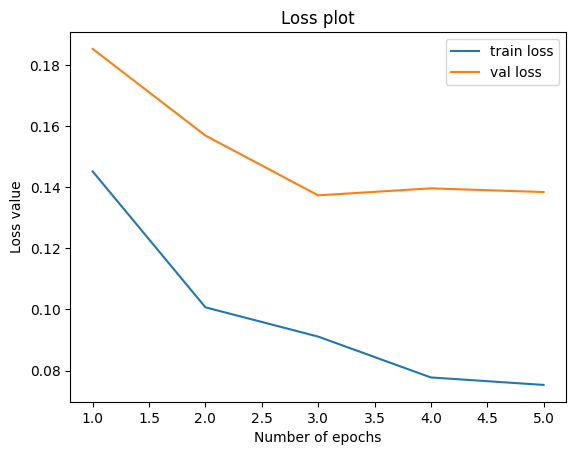

In [ ]:
epochs=[a for a in range(1,num_epochs+1)]
plt.plot(epochs,total_train_loss,label='train loss')
plt.plot(epochs,total_val_loss,label='val loss')
plt.title('Loss plot')
plt.xlabel('Number of epochs')
plt.ylabel('Loss value')

plt.legend()
plt.show()

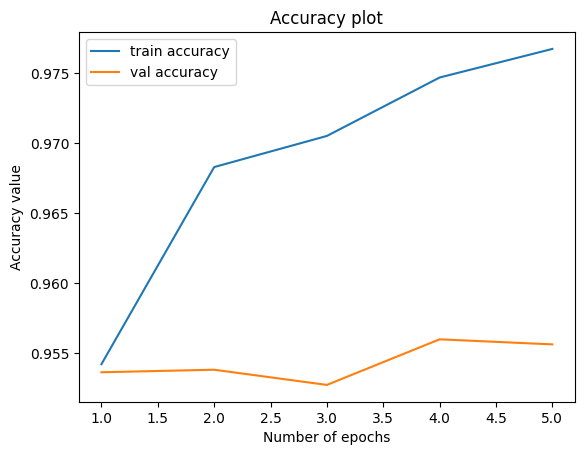

In [ ]:
epochs=[a for a in range(1,num_epochs+1)]
plt.plot(epochs,total_train_accuracy,label='train accuracy')
plt.plot(epochs,total_val_accuracy,label='val accuracy')
plt.title('Accuracy plot')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy value')

plt.legend()
plt.show()

# **Confusion Matrix**

In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_loader)

100%|██████████| 345/345 [00:51<00:00,  6.64it/s]


In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Greens', ax=ax)
    plt.xticks(rotation=20)

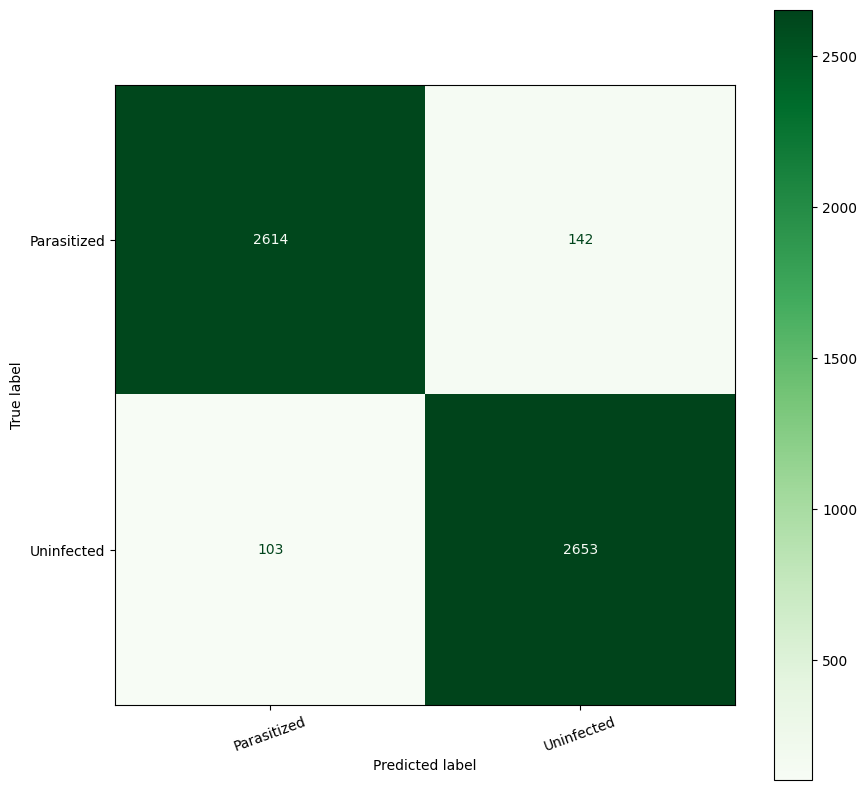

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

In [ ]:
from sklearn.metrics import accuracy_score
# accuracy
accuracy_score(labels,pred_labels)


0.9555515239477503

In [ ]:
from sklearn.metrics import f1_score
#f1 score
f1_score(labels,pred_labels)

0.9558638083228247

In [ ]:
#precision
from sklearn.metrics import precision_score
precision_score(labels, pred_labels)

0.9491949910554561

In [ ]:
#recall
from sklearn.metrics import recall_score
recall_score(labels, pred_labels)

0.9626269956458636